# Load libraries

In [1]:
import fastai
fastai.__version__

'1.0.29.dev0'

In [62]:
from fastai import *
from fastai.tabular import *
from sklearn.model_selection import train_test_split, KFold

In [63]:
%matplotlib inline

# Read in Data

In [72]:
path = Path('../data')

In [64]:
df = pd.read_csv('../data/adult.csv')

In [65]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>=50k
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,1
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,1
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,0


# Preprocessing

## Define column types

In [66]:
dep_var = '>=50k'
num_vars = ['age', 'fnlwgt']#, 'education-num']
cat_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']

In [67]:
df = df.loc[:, num_vars+cat_vars+[dep_var]]

In [290]:
df.shape

(32561, 9)

# One Cycle

In [306]:
n_epochs=[5,10,20]

In [307]:
config = list(itertools.product(n_epochs))

In [291]:
procs = [FillMissing, Categorify, Normalize]

In [292]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [208]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [309]:
all_results = []
for j,param in enumerate(config):
    print(param)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch())

        learn = tabular_learner(data, layers=[256]*3, metrics=accuracy)
        learn.fit_one_cycle(param[0], 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

Total time: 04:14
epoch  train_loss  valid_loss  accuracy
1      0.371316    0.368310    0.825092  (00:12)
2      0.367992    0.359345    0.832156  (00:13)
3      0.379161    0.354630    0.833231  (00:12)
4      0.358474    0.351121    0.834459  (00:11)
5      0.364463    0.356478    0.831849  (00:11)
6      0.362110    0.376358    0.822635  (00:12)
7      0.366525    0.345598    0.837684  (00:11)
8      0.360481    0.346844    0.840909  (00:11)
9      0.353393    0.349437    0.832310  (00:12)
10     0.363678    0.345589    0.840141  (00:12)
11     0.351734    0.344269    0.842138  (00:12)
12     0.350031    0.346472    0.839988  (00:12)
13     0.354928    0.352613    0.841063  (00:15)
14     0.351242    0.349600    0.840448  (00:14)
15     0.349087    0.343218    0.843827  (00:14)
16     0.335967    0.345237    0.842752  (00:12)
17     0.334057    0.343910    0.842445  (00:12)
18     0.338846    0.345751    0.841677  (00:12)
19     0.347028    0.344724    0.843213  (00:12)
20     0.33

In [310]:
all_results = pd.concat(all_results)

In [334]:
all_results.metrics = all_results.metrics.astype(np.float32)

In [339]:
tmp = (all_results.groupby(['experiment', 'epochs']).agg({'metrics':['mean', 'std']}))

In [342]:
tmp.columns = [':'.join(col).strip() for col in tmp.columns.values]

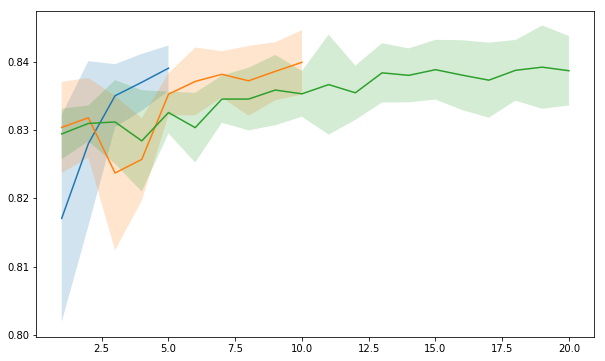

In [345]:
fig, ax = plt.subplots(figsize=(10,6))
# plt.ylim(0.3, 0.4)
for _,exp in tmp.groupby('experiment'):
    epochs = exp.reset_index().epochs
    mu = exp.reset_index()['metrics:mean']
    errors = exp.reset_index()['metrics:std']
    ax.plot(epochs,mu)
    ax.fill_between(epochs, mu-errors, mu+errors, alpha=0.2)

In [ ]:
for j,param in enumerate(config):
    print(param)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch())

        learn = tabular_learner(data, layers=[256]*3, metrics=accuracy)
        learn.fit(param[0], 1e-2)
        results = pd.DataFrame({
            'experiment': j+1+len(config),
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

[(5,), (10,), (20,)]


epoch,train_loss,valid_loss,accuracy
1,0.386080,0.367290,0.821281
2,0.369644,0.356294,0.834638
3,0.357398,0.352179,0.834792
4,0.361243,0.343058,0.841701


In [203]:
all_results.to_csv('layer_number_size_epoch3.csv', index=None)

# Number and Size of Layers

In [204]:
layer_sizes=[32,64,128,256,512,1024,2048]
layer_number=[1,2,4,8]

In [205]:
config = list(itertools.product(layer_sizes, layer_number))

In [206]:
procs = [FillMissing, Categorify, Normalize]

In [207]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [208]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [200]:
all_results = []
for j,param in enumerate(config):
    print(config)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch())

        learn = tabular_learner(data, layers=[param[0]]*param[1], metrics=accuracy)
        learn.fit_one_cycle(3, 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

Total time: 14:49
epoch  train_loss  valid_loss  accuracy
1      0.396025    0.368104    0.834613  (04:56)
2      0.361245    0.360065    0.838759  (04:54)
3      0.350522    0.348898    0.841523  (04:58)



In [ ]:
all_results = pd.concat(all_results)

In [203]:
all_results.to_csv('layer_number_size_epoch3.csv', index=None)

In [210]:
all_results = pd.read_csv('layer_number_size_epoch3.csv')

In [216]:
last_epoch_results = all_results.groupby(['experiment', 'fold']).tail(1)

In [219]:
avg_results = last_epoch_results.groupby('experiment').agg({'valid_loss': ['mean','std'],
                                              'metrics': ['mean','std']})

In [228]:
avg_results.columns = [':'.join(col).strip() for col in avg_results.columns.values]

In [232]:
avg_results.reset_index(inplace=True)

In [234]:
avg_results = avg_results.join(pd.DataFrame(config, columns=['size', 'number']))

In [235]:
avg_results.head(5)

,experiment,valid_loss:mean,valid_loss:std,metrics:mean,metrics:std,size,number
0,1,0.349793,0.005268,0.837935,0.002223,32,1
1,2,0.349517,0.005723,0.836952,0.003160,32,2
2,3,0.349417,0.005096,0.838273,0.002953,32,4
3,4,0.351206,0.004572,0.837382,0.003261,32,8
4,5,0.349468,0.005164,0.838580,0.002497,64,1


In [243]:
plot_df = avg_results.pivot_table(index='size', columns='number', values='metrics:mean')

In [246]:
errors = avg_results.pivot_table(index='size', columns='number', values='metrics:std')

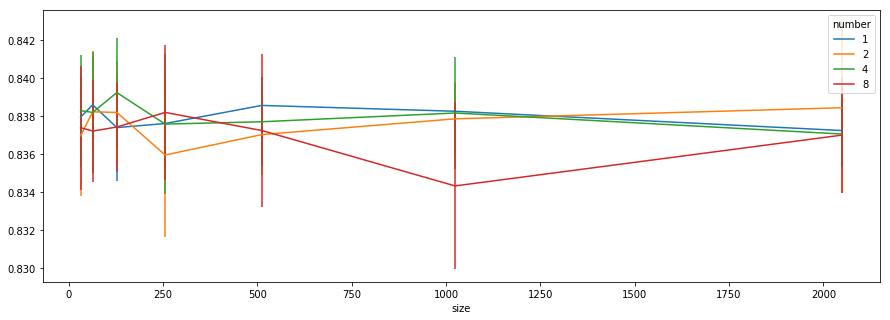

In [253]:
plot_df.plot(yerr=errors, figsize=(15,5))
# plt.fill_between(plot_df.index, plot_df+errors, plot_df-errors)
# plt.ylim(0.34,0.36)

In [257]:
import seaborn as sns

In [270]:
plot_df.index.values

array([  32,   64,  128,  256,  512, 1024, 2048])

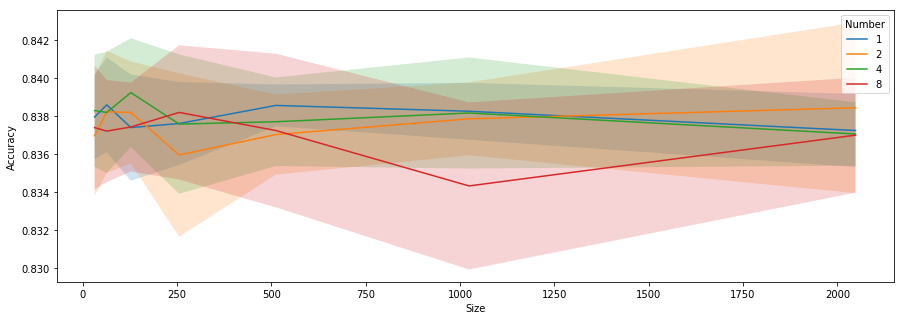

In [274]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel('Size')
ax.set_ylabel('Accuracy')
clrs = sns.color_palette("husl", plot_df.shape[1])
for i in range(plot_df.shape[1]):
    mu = plot_df.iloc[:,i]
    sig = errors.iloc[:,i]
    ax.plot(mu, label=plot_df.columns[i])
    ax.fill_between(plot_df.index.values, mu-sig, mu+sig, alpha=0.2)
ax.legend(title='Number')

# Dropout

In [284]:
layer_sizes=[128,512]
dropout = np.arange(0, 0.99, 0.1)

In [285]:
config = list(itertools.product(layer_sizes, dropout))

In [286]:
procs = [FillMissing, Categorify, Normalize]

In [287]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [288]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
all_results = []
for j,param in enumerate(config):
    print(param)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch())

        learn = tabular_learner(data, layers=[param[0]]*2, ps=[param[1]]*2, metrics=accuracy)
        learn.fit_one_cycle(5, 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

In [ ]:
all_results = pd.concat(all_results)

In [203]:
all_results.to_csv('layer_number_dropout_epoch3.csv', index=None)

# Embedding Sizes

# Feature Scalings

# Sample Size

In [349]:
sample_sizes = [1000,2000,4000,8000,16000,32000]

In [350]:
config = list(itertools.product(sample_sizes))

In [351]:
procs = [FillMissing, Categorify, Normalize]

In [352]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [357]:
all_results = []
for j,param in enumerate(config):
    print(param)
    df_sub = df.sample(param[0], random_state=42).copy().reset_index(drop=True)
    src = TabularList.from_df(df_sub, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)
    for i, (train_ids, valid_ids) in enumerate(kf.split(df_sub)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch())
        learn = tabular_learner(data, layers=[256]*2, metrics=accuracy)
        learn.fit_one_cycle(5, 1e-2)
        results = pd.DataFrame({
            'experiment': j+1,
            'fold': i+1, 'epochs':np.arange(1, len(learn.recorder.metrics)+1),
            'valid_loss': learn.recorder.val_losses,
            'metrics': [np.array(val[0]) for val in learn.recorder.metrics]})
        all_results.append(results)

Total time: 00:49
epoch  train_loss  valid_loss  accuracy
1      0.367863    0.386474    0.833281  (00:10)
2      0.374710    0.372234    0.830156  (00:09)
3      0.361934    0.366826    0.832656  (00:10)
4      0.347930    0.360920    0.833750  (00:09)
5      0.339000    0.359601    0.833125  (00:09)



In [358]:
all_results = pd.concat(all_results)

In [375]:
tmp = all_results.groupby(['experiment', 'epochs']).agg({'valid_loss':['mean', 'std']})
tmp.columns = [':'.join(col).strip() for col in tmp.columns.values]
tmp.reset_index(inplace=True)
mean_df = tmp.pivot(index='epochs', columns='experiment', values='valid_loss:mean')
sig_df = tmp.pivot(index='epochs', columns='experiment', values='valid_loss:std')

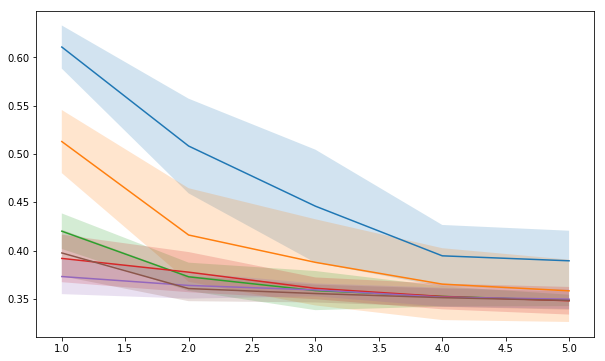

In [379]:
fig, ax = plt.subplots(figsize=(10,6))
# plt.ylim(0.34,0.36)
for i in range(mean_df.shape[1]):
    mu = mean_df.iloc[:,i]
    sig = sig_df.iloc[:,i]
    epochs = mean_df.index.values
    ax.plot(epochs, mu)
    ax.fill_between(epochs, mu-sig, mu+sig, alpha=0.2)

In [203]:
all_results.to_csv('layer_number_dropout_epoch3.csv', index=None)

# Architecture Shape

# SeLU

In [ ]:
nn.SELU()

# Residual Connections

In [ ]:
def forward(self, x):
    residual = x
    x = self.layer(x)
    x += residual
    return x

# Attention

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

# Augmentation Strategies

# Pretraining

## Process categoricals

**Note**: missing values are not yet treated

In [12]:
categories={}
for col in cat_vars:
    train_df.loc[:, col] = train_df.loc[:, col].astype('category').cat.as_ordered()
    categories.update({col:train_df.loc[:, col].cat.categories.values})
    test_df.loc[:, col] = pd.Categorical(test_df.loc[:, col], categories=categories[col], ordered=True)

still need to choose how to represent them, either one-hot or integer encoded

One-hot encode

In [13]:
for col in cat_vars:
    train_df = train_df.drop(columns=col).join(pd.get_dummies(train_df.loc[:,col], prefix=col))
    test_df = test_df.drop(columns=col).join(pd.get_dummies(test_df.loc[:,col], prefix=col))

In [14]:
train_df.head()

,age,fnlwgt,>=50k,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,45,167523,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,44,126199,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,55,37438,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,34,143766,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,46,167159,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Process numerics

In [15]:
for col in num_vars:
    train_df.loc[:, col] = train_df[col].astype(np.float32)
    test_df.loc[:, col] = test_df[col].astype(np.float32)

### Choose normalisation

Standard 0 mean and unit variance scaling

In [16]:
stats={}
for col in num_vars:
    stats.update({col: np.array([train_df[col].mean(), train_df[col].std()])})
    train_df.loc[:,col] = (train_df[col]-stats[col][0])/stats[col][1]
    test_df.loc[:,col] = (test_df[col]-stats[col][0])/stats[col][1]

In [17]:
stats

{'age': array([38.588524, 13.686339]),
 'fnlwgt': array([189604.40625 , 104962.476562])}

## Dataset

In [18]:
class TabularDataset(Dataset):
    def __init__(self, df, dep_var):
        self.x = df.drop(columns=dep_var).values
        self.y = df[dep_var].values
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.get_x(idx)
        y = self.get_x(idx)
        return (x, y)
    
    def get_x(self, idx):
        return torch.tensor(self.x[idx,:], dtype=torch.float32)
    
    def get_y(self, idx):
        return torch.tensor(self.y[idx], dtype=torch.int64)

In [19]:
train_ds = TabularDataset(train_df, dep_var)
test_ds = TabularDataset(test_df, dep_var)

## Data loader

In [20]:
bs=64

In [21]:
train_dl = DataLoader(train_ds, batch_size=bs)
test_dl = DataLoader(test_ds, batch_size=bs)

In [22]:
x, y = next(iter(train_dl))

In [24]:
print(x.shape, y.shape)

torch.Size([64, 60]) torch.Size([64, 60])


In [25]:
data = DataBunch(train_dl, test_dl)

# Model

In [95]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        sizes = [60, 200, 200, 2]
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,act) in enumerate(zip(sizes[:-1],sizes[1:],actns)):
            layers += bn_drop_lin(n_in, n_out, bn=False, p=0, actn=act)
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [43]:
class DAE(nn.Module):
    def __init__(self):
        super().__init__()
        sizes = [60, 200, 200, 60]
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,act) in enumerate(zip(sizes[:-1],sizes[1:],actns)):
            layers += bn_drop_lin(n_in, n_out, bn=False, p=0, actn=act)
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [44]:
m = DAE()

In [45]:
m

DAE(
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=200, out_features=60, bias=True)
  )
)

In [46]:
x_batch, y_batch = next(iter(train_dl))

In [47]:
m(x_batch).shape

torch.Size([64, 60])

In [48]:
learn = Learner(data, m, metrics=None, loss_func=F.mse_loss)

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


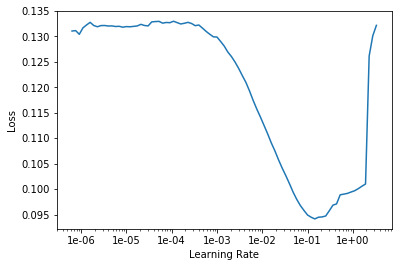

In [50]:
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(3, 1e-2)

Total time: 00:10
epoch  train_loss  valid_loss
1      0.003137    0.003181    (00:03)
2      0.000648    0.000430    (00:03)
3      0.000052    0.000055    (00:03)



In [52]:
m.eval()

DAE(
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=200, out_features=60, bias=True)
  )
)

In [53]:
m(x_batch)

tensor([[ 0.4682, -0.2084, -0.0009,  ..., -0.0007,  0.0003,  0.9998],
        [ 0.3922, -0.5888,  0.0005,  ...,  0.0012,  0.0048,  0.9942],
        [ 1.1826, -1.4442,  0.0016,  ..., -0.0002, -0.0019,  1.0065],
        ...,
        [-0.4199, -0.6836, -0.0034,  ..., -0.0032,  0.0053,  0.9925],
        [ 0.2455, -0.8040,  0.0040,  ..., -0.0051, -0.0063,  1.0067],
        [-0.1169, -1.1652, -0.0095,  ..., -0.0034, -0.0037,  1.0045]],
       grad_fn=<ThAddmmBackward>)

In [54]:
x_batch

tensor([[ 0.4685, -0.2104,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.3954, -0.6041,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 1.1991, -1.4497,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [-0.4083, -0.6732,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.2493, -0.8124,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [-0.1161, -1.1711,  0.0000,  ...,  0.0000,  0.0000,  1.0000]])

In [84]:
learn.fit(10, 0.01)

Total time: 00:25
epoch  train_loss  valid_loss
1      0.347521    0.344244    (00:02)
2      0.343011    0.344807    (00:02)
3      0.341174    0.347008    (00:02)
4      0.337883    0.347670    (00:02)
5      0.333931    0.351055    (00:02)
6      0.332627    0.355039    (00:02)
7      0.327785    0.360182    (00:02)
8      0.326168    0.354243    (00:02)
9      0.324182    0.356167    (00:02)
10     0.318789    0.365484    (00:02)

